<a href="https://colab.research.google.com/github/HabibTriki/MedicalClassificationCNN/blob/main/Classifying_medical_images_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/MedNIST.zip"
!unzip -qo "MedNIST.zip"
!rm "MedNIST.zip"

--2024-02-16 22:43:14--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/MedNIST.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.66.112, 52.219.160.103, 52.219.66.96, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.66.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110557154 (105M) [application/x-zip-compressed]
Saving to: ‘MedNIST.zip’

MedNIST.zip         100%[===================>] 105.43M  12.6MB/s    in 10s     

2024-02-16 22:43:25 (10.4 MB/s) - ‘MedNIST.zip’ saved [110557154/110557154]



In [ ]:
test_dir = "Medical/Medical_test"
train_dir = "Medical/Medical_train"

In [ ]:
import os
import numpy as np
import pandas as pd
import random, datetime, os, shutil, math

In [ ]:
def prep_test_data(med, train_dir , test_dir):
  pop = os.listdir(train_dir+'/'+med)
  test_data=random.sample(pop,2000)
  #print(test_data)
  for f in test_data :
    shutil.copy(train_dir+'/'+med+'/'+f,test_dir+'/'+med+'/')
for medi in os.listdir(train_dir):
  prep_test_data(medi,train_dir,test_dir)

target_classes = os.listdir(train_dir)
num_classes = len(target_classes)
print('Number of target classes:', num_classes)
print(list(enumerate(target_classes)))

In [ ]:
target_classes = os.listdir(train_dir)
num_classes = len(target_classes)
print('Number of target classes:', num_classes)
print(list(enumerate(target_classes)))

Number of target classes: 6
[(0, 'BreastMRI'), (1, 'AbdomenCT'), (2, 'ChestCT'), (3, 'HeadCT'), (4, 'Hand'), (5, 'CXR')]


In [ ]:
training_set_distribution = [len(os.listdir(os.path.join(train_dir,
dir))) for dir in os.listdir(train_dir)]
testing_set_distribution = [len(os.listdir(os.path.join(test_dir,
dir))) for dir in os.listdir(test_dir)]

In [ ]:
def show_mri(med):
  num=len(med)
  if(num==0):
    return None
  rows = int(math.sqrt(num))
  cols=(num+1)//rows
  f, axs = plt.subplots(rows, cols)
  fig = 0
  for b in med:
    img = image.load_img(b)
    row = fig // cols
    col = fig % cols
    axs[row, col].imshow(img)
    fig += 1
  plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

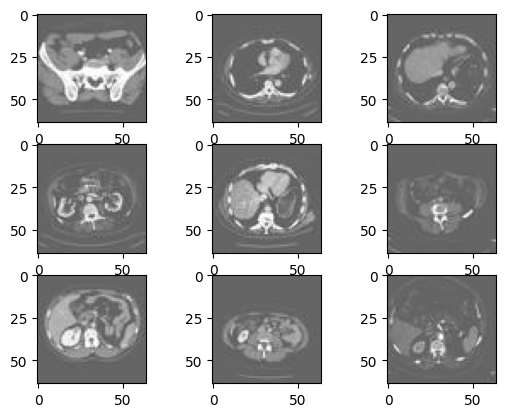

In [ ]:
dir_name = os.path.join(train_dir,"AbdomenCT")
all_images = [os.path.join(dir_name, fname) for fname in os.listdir(dir_name)]
show_mri(all_images[:9])

In [ ]:
image_size = (32, 32, 3)
datagen=ImageDataGenerator(rescale = 1./255,
                           shear_range=0.2,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           )

In [ ]:
training_set=datagen.flow_from_directory(train_dir,
                                         target_size=image_size[:2],
                                         batch_size=32,
                                         class_mode='categorical',
                                         shuffle=False
                                         #color_mode='rgb'
                                         )

Found 58954 images belonging to 6 classes.


In [ ]:
validation_set=datagen.flow_from_directory(test_dir,
                                           target_size=image_size[:2],
                                           batch_size=32,
                                           class_mode='categorical',
                                           shuffle=False
                                           )

Found 21580 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import plot_model

In [ ]:
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=7)
filepath = "modelMedicalMNIST.h5"
ckpt = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
rlp = ReduceLROnPlateau(monitor='acc', patience=3, verbose=1)

In [ ]:
def cnn(image_size, num_classes):
    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return classifier

neuralnetwork_cnn = cnn(image_size, num_classes)
neuralnetwork_cnn.summary()
#plot_model(neuralnetwork_cnn, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 6)                 4

In [ ]:
history = neuralnetwork_cnn.fit_generator(
    generator=training_set, validation_data=validation_set,
    callbacks=[es, ckpt, rlp], epochs = 5,
)

Epoch 1/5


<ipython-input-19-d53212ee6f04>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = neuralnetwork_cnn.fit_generator(


1843/1843 [==============================] - ETA: 0s - loss: 0.2204 - acc: 0.9315
Epoch 1: acc improved from -inf to 0.93147, saving model to modelMedicalMNIST.h5
1843/1843 [==============================] - 298s 161ms/step - loss: 0.2204 - acc: 0.9315 - val_loss: 0.0400 - val_acc: 0.9920 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/5
1843/1843 [==============================] - ETA: 0s - loss: 0.0407 - acc: 0.9895
Epoch 2: acc improved from 0.93147 to 0.98948, saving model to modelMedicalMNIST.h5
1843/1843 [==============================] - 292s 158ms/step - loss: 0.0407 - acc: 0.9895 - val_loss: 0.0129 - val_acc: 0.9972 - lr: 0.0010
Epoch 3/5
1843/1843 [==============================] - ETA: 0s - loss: 0.0166 - acc: 0.9957
Epoch 3: acc improved from 0.98948 to 0.99567, saving model to modelMedicalMNIST.h5
1843/1843 [==============================] - 285s 155ms/step - loss: 0.0166 - acc: 0.9957 - val_loss: 0.0212 - val_acc: 0.9945 - lr: 0.0010
Epoch 4/5
1843/1843 [==============================] - ETA: 0s - loss: 0.0191 - acc: 0.9945
Epoch 4: acc did not improve from 0.99567
1843/1843 [==============================] - 291s 158ms/step - loss: 0.0191 - acc: 0.9945 - val_loss: 0.0066 - val_acc: 0.9981 - lr: 0.0010
Epoch 5/5
1843/1843 [==============================] - ETA: 0s - loss: 0.0932 - acc: 0.9896
Ep

fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).iloc[:, :-1].plot(ax=ax)

In [ ]:
batch_size=32
pred=neuralnetwork_cnn.predict_generator(validation_set,steps=306/batch_size)
predicted_class_indices=np.argmax(pred,axis=1)


<ipython-input-21-e16df5100bce>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=neuralnetwork_cnn.predict_generator(validation_set,steps=306/batch_size)


In [ ]:
labels = (validation_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
filenames=validation_set.filenames[0]
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
display(results.head(50))

,Filename,Predictions
0,AbdomenCT/000000.jpeg,AbdomenCT
1,AbdomenCT/000000.jpeg,AbdomenCT
2,AbdomenCT/000000.jpeg,AbdomenCT
3,AbdomenCT/000000.jpeg,AbdomenCT
4,AbdomenCT/000000.jpeg,AbdomenCT
5,AbdomenCT/000000.jpeg,AbdomenCT
6,AbdomenCT/000000.jpeg,AbdomenCT
7,AbdomenCT/000000.jpeg,AbdomenCT
8,AbdomenCT/000000.jpeg,AbdomenCT
9,AbdomenCT/000000.jpeg,AbdomenCT
